## Covid19 Analysis & Forecast
##### by Khairul Omar

### 1. Import data

In [1]:
# Import libraries
import pandas as pd
pd.options.display.max_rows = 200
import numpy as np
import math
import json
import requests
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

In [2]:
# # Multiple downloads from John Hopkins Hospital database
# start  = pd.to_datetime(f'20200122', format='%Y%m%d')
# oneday = pd.Timedelta(1, unit='days')
# end    = pd.to_datetime(f'20200315', format='%Y%m%d')
# for d in range((end - start).days+1):
#     date = start + oneday * d
#     day, month, year = str(date)[8:10], str(date)[5:7], str(date)[:4]
#     url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month}-{day}-{year}.csv'
#     df = pd.read_csv(url)
#     df.to_csv(f'csv/{month}-{day}-{year}.csv')

In [3]:
# One-day download from John Hopkins Hospital database
day = 27
month = 3
date  = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
day0, month0, year0 = str(date)[8:10], str(date)[5:7], str(date)[:4]
url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month0}-{day0}-{year0}.csv'
zero = 0 if day < 10 else ''
df = pd.read_csv(url)
df.to_csv(f'csv2/0{month}-{zero}{day}-2020.csv')

In [4]:
# Process files with formatting prior to 23/03/2020
path = 'csv/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country/region':'country'})
        df0 = df0.rename(columns={'province/state':'state'})
        df0 = df0.rename(columns={'last update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        df0['fips'] = 0
        for col in ['confirmed','deaths','recovered']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
    df01 = df.copy()
        
# Process files with formatting from 23/03/2020
path = 'csv2/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country_region':'country'})
        df0 = df0.rename(columns={'province_state':'state'})
        df0 = df0.rename(columns={'last_update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered','fips','admin2']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        for col in ['confirmed','deaths','recovered', 'fips']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
    df02 = df.copy()

df = pd.concat([df02, df01])
df0 = df.copy()

In [5]:
df = df0.copy()

# Geo clean-up mapping dictionary
geo = json.load(open('geo.json'))
df.country = df.country.apply(lambda row: geo['countries'][row] if row in list(geo['countries'].keys()) else row)
df['temp'] = ''
for i in range(len(df)):
    state = df.iloc[i].state
    country = df.iloc[i].country
    if state in ['Channel Islands', 'Gibraltar', 'Cayman Islands',
                 'Faroe Islands']:
        df.iloc[i, df.columns.get_loc('country')] = df.iloc[i, df.columns.get_loc('state')]
    elif (state == country) | (state == 'None') | (state == 'UK'):
        df.iloc[i, df.columns.get_loc('state')] = country
    elif state.find('Princess') > 0:
        if country != 'Cruise Ship':
            df.iloc[i, df.columns.get_loc('state')] = f'Cruise {country}'
        else:
            df.iloc[i, df.columns.get_loc('state')] = 'Cruise Ship'
    elif country == 'United States':
        if state == 'Washington, D.C.':
            s = 'District of Columbia'
        elif state == 'US':
            s = 'Unassigned'
        elif state == 'Chicago':
            s = 'Illinois'
        elif (state == "Virgin Islands, U.S.") | (state == "United States Virgin Islands"):
            s = 'Virgin Islands'
        elif state.find(', ') > 0:
            s0 = state[state.find(', ')+2:state.find(', ')+4]
            s = geo['us_states'][s0]
        elif state in list(geo['us_states'].keys()):
            s = geo['us_states'][state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s
    elif country == 'Canada':
        if state.find('Princess') > 0:
            s = 'Cruise Ship'               
        elif state.find(', ') > 0:
            ca = {'Edmonton, Alberta':'Alberta', 'Calgary, Alberta':'Alberta',
                  'London, ON':'Ontario', 'Toronto, ON':'Ontario', ' Montreal, QC':'Quebec'}
            s = ca[state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s

df['state'] = df.apply(lambda row: row['temp'] if row['temp']!='' else (row['state'] if row['state']!='' else row['country']), axis=1)
df.drop('temp', axis=1, inplace=True)

df = pd.pivot_table(df, values=['confirmed','deaths','recovered'], index=['date','updated','country','state'], columns=None, aggfunc='sum')
df = df.rename(columns={'confirmed':'confirmed_raw'})
df = df.reset_index()
dftemp = pd.DataFrame()
for state in df.state.unique():
    dfstate = df[df.state==state].copy()
    dfstate = dfstate.sort_index(ascending=False)
    dfstate['confirmed'] = dfstate.confirmed_raw
    # Replace raw with average between 2 dates due to incomplete data due to cut-off reporting time
    # e.g. if new cases suddenly drop by 90% in one day, most likely it's due to incomplete data
    for i in range(1,len(dfstate.index)-1):
        ratio = 1/2 # smoothing average ratio
        if dfstate.iloc[i+1].confirmed_raw / dfstate.iloc[i].confirmed_raw > 0.9:
            dfstate.iloc[i, dfstate.columns.get_loc('confirmed')] = int(dfstate.iloc[i+1].confirmed_raw * ratio
                                                                        + dfstate.iloc[i-1].confirmed_raw * (1-ratio))
    for col in ['confirmed','deaths','recovered']:
        colname = f'new_{col}'
        dfstate[colname] = dfstate[col].diff(-1)
        dfstate[colname] = dfstate[colname].fillna(dfstate[col])
        dfstate[colname] = dfstate[colname].astype('int')
    dftemp =  pd.concat([dftemp, dfstate])
df = dftemp.sort_values(['date','new_confirmed'], ascending=False)
allcols = ['date','updated', 'country', 'state', 'confirmed', 'deaths', 'recovered', 'new_confirmed', 'new_deaths', 'new_recovered']
df = df[allcols]
df = df.reset_index(drop=True)

In [6]:
# Country-level data
df1 = pd.pivot_table(df, values=df.columns[4:], index=['date','country'], columns=None, aggfunc='sum')
df1 = df1.reset_index()
df1 = df1.sort_values(['date','confirmed'], ascending=False)
df1 = df1[['date','country'] + allcols[-6:]]
df1 = df1.set_index('date')

### 2. Analyse latest data

In [7]:
# Display one day data
day = day
month = month
date = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
oneday = pd.Timedelta(1, unit='days')

top0 = 50
latest = df1.loc[date]
print(f'\nTop {top0} countries by total cases as of {date.day}/{date.month}/2020')
display(latest[:top0])


Top 50 countries by total cases as of 27/3/2020


,country,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,
2020-03-27,United States,101657,1581,869,17734,372,685
2020-03-27,Italy,86498,9134,10950,6056,919,589
2020-03-27,China,81897,3296,74720,120,5,539
2020-03-27,Spain,65719,5138,9357,7933,773,2342
2020-03-27,Germany,50871,342,6658,6933,75,985
2020-03-27,France,33402,1997,5707,3836,299,752
2020-03-27,Iran,32332,2378,11133,2658,144,676
2020-03-27,United Kingdom,14594,759,137,2890,181,0
2020-03-27,Switzerland,12928,231,1530,1016,40,1399



New confirmed cases from 1/2/2020 to 27/3/2020


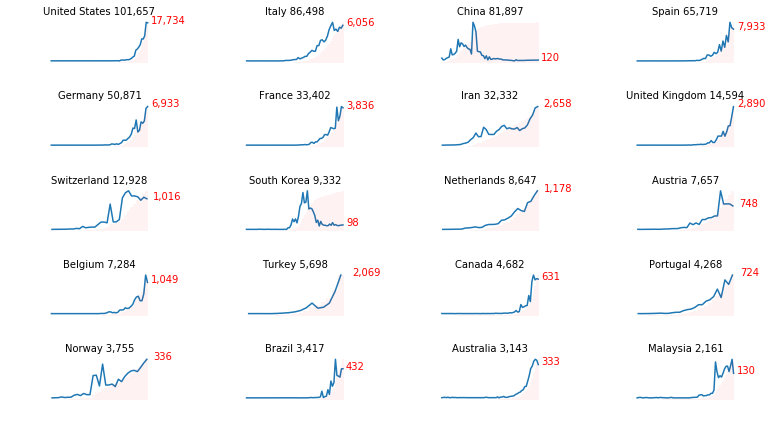

In [8]:
top = 20
# Select diplay data
until = date
data = df1[until:]

# Plot data
print(f'\nNew confirmed cases from 1/2/2020 to {date.day}/{date.month}/2020')
countries = list(latest[:top-2].country) + ['Australia', 'Malaysia']
# countries.remove('Cruise Ship')
fig, axes = plt.subplots(ncols=4, nrows=round(len(countries)/4), figsize=(11,6), constrained_layout=True)
for i, ax in zip(range(len(countries)), axes.flat):
    cdata = data[data.country==countries[i]]
    ax.plot(cdata.new_confirmed)
    ax.text(until + oneday*2, cdata.loc[until].new_confirmed, format(cdata.loc[until].new_confirmed, ","), color='red')
    ax2 = ax.twinx()
    ax2.bar(cdata.index, cdata.confirmed, color='red', alpha=0.05, width=1)
    ax.set_title(f'{countries[i]} {format(cdata.loc[until].confirmed, ",")}', fontsize=10)
    ax.axis('off')
    ax2.axis('off')
plt.tight_layout()
plt.show()

In [9]:
print(f'\nNew confirmed cases by Top 10 US State as of {date.day}/{date.month}/2020')
usa = df[df.country=='United States'].set_index('date').iloc[:10,2:]
usa


New confirmed cases by Top 10 US State as of 27/3/2020


,state,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,
2020-03-27,New York,44876,527,0,6999,142,0
2020-03-27,New Jersey,8825,108,0,1949,27,0
2020-03-27,Massachusetts,3240,35,0,823,10,0
2020-03-27,Michigan,3634,92,0,789,31,0
2020-03-27,California,4657,94,0,758,13,0
2020-03-27,Pennsylvania,2345,22,0,550,4,0
2020-03-27,Florida,2900,35,0,543,6,0
2020-03-27,Illinois,3024,34,0,486,8,0
2020-03-27,Georgia,2000,64,0,475,16,0


In [10]:
print(f'\nNew confirmed cases by Top 10 US County as of {date.day}/{date.month}/2020')
county = df0.loc[(df0.country=='US') & (df0.date==date)].sort_values(by='confirmed', ascending=False)[:10].set_index('date', drop=True)
county = county[['admin2', 'state', 'confirmed', 'deaths', 'recovered']]
county


New confirmed cases by Top 10 US County as of 27/3/2020


,admin2,state,confirmed,deaths,recovered
date,,,,,
2020-03-27,New York City,New York,25573,366,0
2020-03-27,Westchester,New York,7187,1,0
2020-03-27,Nassau,New York,4657,19,0
2020-03-27,Suffolk,New York,3385,30,0
2020-03-27,Cook,Illinois,2239,20,0
2020-03-27,Unassigned,New Jersey,1984,82,0
2020-03-27,Wayne,Michigan,1810,37,0
2020-03-27,King,Washington,1577,109,0
2020-03-27,Bergen,New Jersey,1505,6,0


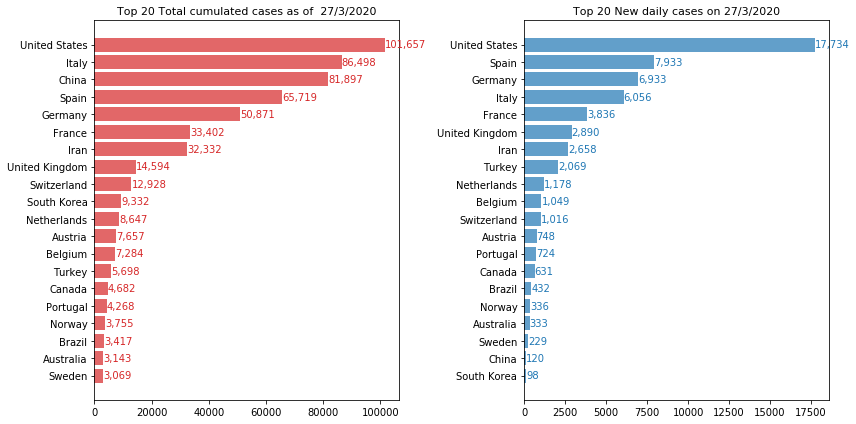

In [11]:
cols = ['confirmed','new_confirmed']
titles = ['Total cumulated cases as of  ','New daily cases on ']
colors = ['C3','C0']
fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
for i, ax in zip(range(len(cols)), axes.flat):
    data = latest[:top][['country',cols[i]]].reset_index(drop=True).set_index('country').sort_values(by=cols[i])
    ax.barh(data.index, data[cols[i]], color=colors[i], alpha=0.7)
    ax.set_title(f'Top {top} {titles[i]}{date.day}/{date.month}/2020', fontsize='11')
    for n, v in enumerate(data[cols[i]]):
        ax.text(v, n, format(v, ","), va='center', fontsize=10, color=colors[i])
plt.tight_layout()
plt.savefig('img/total_cases_bar', pad_inches=0)
plt.show()

In [12]:
rolling_window = 2
df2 = df1[['country', 'confirmed', 'new_confirmed']].sort_index().reset_index()
threshold = 50
dftemp = pd.DataFrame()
for country in df2.country.unique():
    dfc = df2[df2.country==country].copy().reset_index(drop=True)
    dfc['growth'] = 0
    dfc['new_growth'] = 0
    for i in range(1,len(dfc.index)):
        for newcol in ['growth', 'new_growth']:
            oldcol = 'confirmed' if newcol == 'growth' else 'new_confirmed'
            dfc.iloc[i, dfc.columns.get_loc(newcol)] = 0 if dfc.iloc[i-1][oldcol] == 0 else round(dfc.iloc[i][oldcol]/dfc.iloc[i-1][oldcol],2)
    dftemp =  pd.concat([dftemp, dfc])
df2 = dftemp[dftemp.confirmed > threshold] # ignore cases below 50
df2['growth_avg'] = round(df2.growth.rolling(window=rolling_window).mean(),2)
df2 = df2.reset_index(drop=True)

In [13]:
print(f'\nTop 20 countries with the highest day-on-day growth as of {date.day}/{date.month}/2020')
growthdata = df2.loc[(df2.date==date) & (df2.confirmed > 100)].sort_values(by='growth', ascending=False).set_index('country', drop=True)
growthdata[['confirmed','growth','growth_avg']][:20]


Top 20 countries with the highest day-on-day growth as of 27/3/2020


,confirmed,growth,growth_avg
country,,,
Ukraine,310,1.58,1.46
Turkey,5698,1.57,1.53
Kazakhstan,150,1.35,1.36
Azerbaijan,165,1.35,1.26
New Zealand,368,1.30,1.34
South Africa,1170,1.26,1.28
Romania,1292,1.26,1.20
Morocco,345,1.25,1.23
United Kingdom,14594,1.25,1.23



Day-to-day % growth of new confirmed cases for 4 weeks prior to 27/3/2020


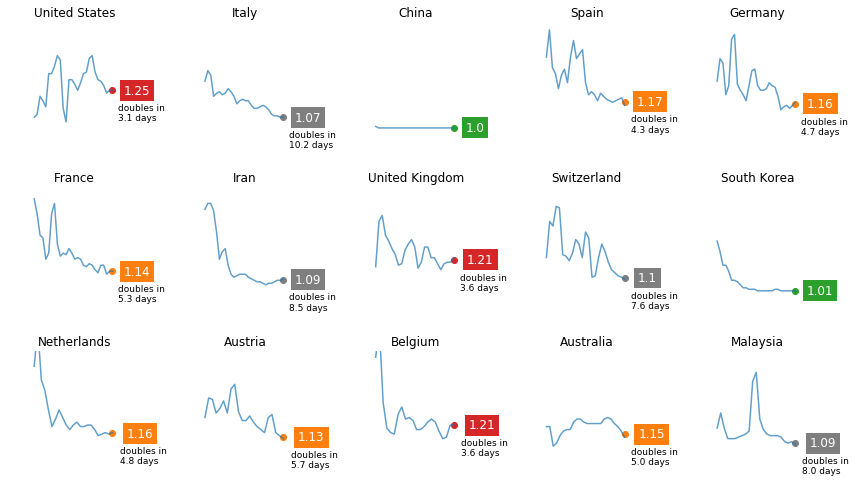

In [14]:
countries = list(latest[:13].country) + ['Australia', 'Malaysia']

print(f'\nDay-to-day % growth of new confirmed cases for 4 weeks prior to {date.day}/{date.month}/2020')
fig, axes = plt.subplots(ncols=5, nrows=round(len(countries)/5), figsize=(12,7), constrained_layout=True)
col = ['growth_avg']
for i, ax in zip(range(len(countries)), axes.flat):
    data = df2[df2.country==countries[i]].iloc[-28:].reset_index(drop=True)
    ax.plot(data[col].clip(1)[:], alpha=0.7)
    latest_growth = data[col].rolling(window=2).mean().iloc[-1]
    if latest_growth[0] < 2**(1/14):
        color = 'C2'
    elif latest_growth[0] < 2**(1/7):
        color = 'C7'
    elif latest_growth[0] < 2**(1/4):
        color = 'C1'
    else: color = 'C3'
    double_days = f'doubles in\n{round(math.log(2)/math.log(latest_growth),1)} days' if latest_growth[0] > 2**(1/30) else ''
    ax.scatter(data.index.max(), latest_growth, marker='o', color=color)
    #ax.hlines(0,data.index.min(),data.index.max(), alpha=0.1)
    ax.text(data.index.max()+4, latest_growth, str(round(latest_growth[0],2)),
            color='white', ha='left', va='center', size=12, bbox=dict(facecolor=color, edgecolor='none'))
    ax.text(data.index.max()+2, latest_growth-0.15, double_days, ha='left', va='center', size=9)
    ax.set_ylim(0.9, 1.7)
    ax.axis('off')
    ax.set_title(countries[i], fontsize=12)
plt.tight_layout()
plt.savefig('img/growth', pad_inches=0)
plt.savefig(f'img_archive/growth_{str(date)[:10]}', pad_inches=0)
plt.show()

In [15]:
print('Day-to-day % growth of new confirmed cases over the past 7 days')
top_countries = list(latest[:13].country) + ['Malaysia', 'Australia']
dfgrowth = pd.pivot_table(df2, values=['growth'], index=['country'], columns=['date'], aggfunc='sum').iloc[:,-7:].loc[top_countries]
dfgrowth

Day-to-day % growth of new confirmed cases over the past 7 days


growth                                              \
date           2020-03-21 2020-03-22 2020-03-23 2020-03-24 2020-03-25   
country                                                                 
United States        1.34       1.30       1.31       1.24       1.22   
Italy                1.14       1.10       1.09       1.08       1.08   
China                1.00       1.00       1.00       1.00       1.00   
Spain                1.24       1.13       1.22       1.14       1.24   
Germany              1.12       1.12       1.17       1.14       1.13   
France               1.14       1.12       1.24       1.12       1.13   
Iran                 1.06       1.06       1.06       1.08       1.08   
United Kingdom       1.26       1.13       1.17       1.22       1.18   
Switzerland          1.24       1.17       1.14       1.12       1.10   
South Korea          1.01       1.01       1.01       1.01       1.01   
Netherlands          1.21       1.16       1.13       1.17       1.15   
Austria              1.18       1.15       1.38       1.18       1.15   
Belgium              1.25       1.21       1.13       1.11       1.16   
Malaysia             1.15       1.14       1.12       1.09       1.10   
Australia            1.26       1.27       1.23       1.22       1.19   

                                      
date           2020-03-26 2020-03-27  
country                               
United States        1.28       1.21  
Italy                1.07       1.08  
China                1.00       1.00  
Spain                1.17       1.14  
Germany              1.18       1.16  
France               1.15       1.13  
Iran                 1.09       1.09  
United Kingdom       1.22       1.25  
Switzerland          1.10       1.09  
South Korea          1.01       1.01  
Netherlands          1.16       1.16  
Austria              1.13       1.11  
Belgium              1.26       1.17  
Malaysia             1.11       1.06  
Australia            1.15       1.12

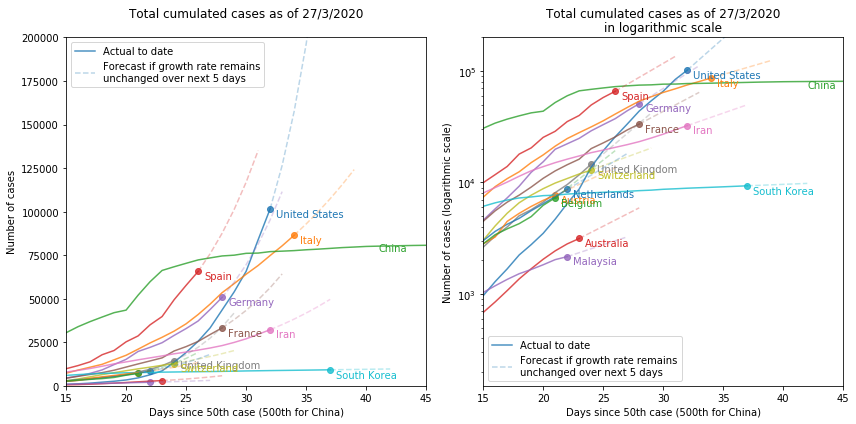

In [38]:
xmax = 45
future_days = 5
ylabels = ['Number of cases', 'Number of cases (logarithmic scale)']
latestdate = f'{date.day}/{date.month}/2020'
titles = [f'Total cumulated cases as of {latestdate}\n',
          f'Total cumulated cases as of {latestdate}\nin logarithmic scale']
fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=2) 
for s in range(2): # one for log scale, one for regular scale
    for i, country in enumerate(countries):
        color = f'C{i}' if i < 10 else f'C{str(i)[-1]}'   
        # Data for actual
        data = df2.loc[(df2.country==country), 'confirmed'].reset_index(drop=True)
        ax[s].plot(data, alpha=0.8, color=color, label='Actual to date')
        ax[s].scatter(data.index.max(), data.iloc[-1], alpha=0.8, color=color)
        if s==0:
            if i<10 : ax[s].text(xmax-4 if country=='China' else data.index.max()+0.5, data.max(), country,
                                 va='top', ha='left', fontsize=10, color=color)
        else:
            ax[s].text(xmax-3 if country=='China' else data.index.max()+0.5, data.max(), country,
                       va='top', ha='left', fontsize=10, color=color)
        # Data for forecast
        latest_growth = df2.loc[(df2.country==country), 'growth'].rolling(window=2).mean().iloc[-1]
        latest_total = df2.loc[(df2.country==country), 'confirmed'].iloc[-1]
        extrapolate = [data.iloc[-1]]
        new_data = latest_total
        for day in range(future_days):
            new_data = new_data * latest_growth
            extrapolate.append(new_data)
        xdays = range(data.index.max(), data.index.max()+future_days+1)
        ax[s].plot(xdays, extrapolate, alpha=0.3, ls='dashed', color=color, label=f'Forecast if growth rate remains\nunchanged over next {future_days} days')
        if i==0: ax[s].legend()
    if s==1: plt.yscale('log')
    ax[s].set_title(titles[s])
    ax[s].set_xlim(xmax-30, xmax)
    ax[s].set_ylim(1.5e2, 2e5)
    ax[s].set_ylabel(ylabels[s])
    ax[s].set_xlabel('Days since 50th case (500th for China)')
plt.tight_layout()
plt.savefig(f'img/total_cases', pad_inches=0)
plt.savefig(f'img_archive/total_cases_{str(date)[:10]}', pad_inches=0)
plt.show()

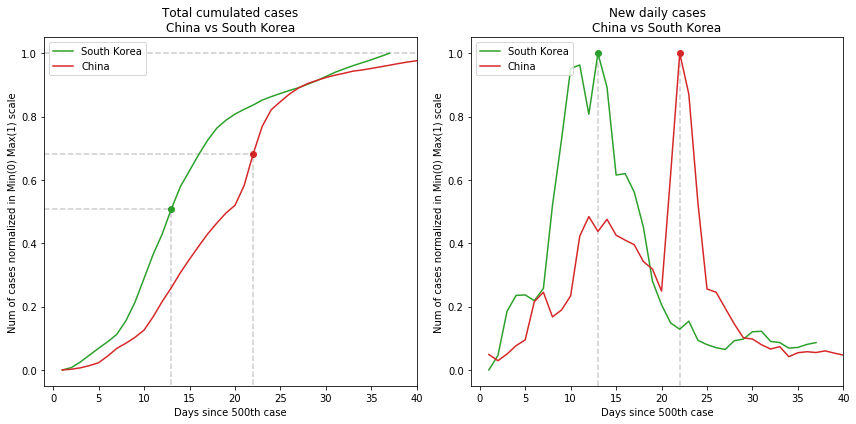

In [17]:
color = ['C2','C3']
cols = ['confirmed','new_confirmed']
titles = ['Total cumulated cases\nChina vs South Korea', 'New daily cases\nChina vs South Korea']
fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
for i, ax in zip(range(len(cols)), axes.flat):
    for c, country in enumerate(['South Korea','China']):
        data0 = df2.loc[df2.confirmed > 500]
        data1 = df2.loc[df2.country==country][cols[i]].rolling(2).sum().reset_index(drop=True)
        if i==1:
            peakday = data1[data1==data1.max()].index[0]
        else:
            data2 = df2.loc[df2.country==country][cols[i+1]].rolling(2).sum().reset_index(drop=True)
            peakday = data2[data2==data2.max()].index[0]
        scaler = MinMaxScaler()
        data = scaler.fit_transform(np.array(data1).reshape(-1, 1))
        ax.plot(data, label=country, color=color[c])
        if i==1:
            ax.vlines(peakday, -0.05, 1, linestyle='dashed', alpha=0.2)
            ax.scatter(peakday, 1, marker='o', color=color[c])
        else:
            ax.vlines(peakday, -1, data[peakday], linestyle='dashed', alpha=0.2)
            ax.hlines(data[peakday], -1, peakday, linestyle='dashed', alpha=0.2)
            ax.hlines(1, -1, xmax, linestyle='dashed', alpha=0.1)
            ax.scatter(peakday, data[peakday], marker='o', color=color[c])
        ax.set_title(titles[i])
        ax.set_xlim(-1, xmax)
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel('Num of cases normalized in Min(0) Max(1) scale')
        ax.set_xlabel('Days since 500th case')
        ax.legend(loc='upper left')
        plt.tight_layout()
plt.savefig('img/china_korea', pad_inches=0)
plt.show()

### Forecasting

In [18]:
# country='United Kingdom'
# rolling=1
# days=50
# fit_start='20200311'
# fit_end='20200320'
# showzero=True
# showpeak=True
# A=None
# K=None
# C=None
# Q=None
# B=None
# v=None

# Generalised logistic function (Richard's curve)
def richards(x, A, K, C, Q, B, v):
    y = A + (K-A) / ((C + (Q * np.exp(-1 * B * x))) ** (1/v))
    return y

# Fit to Richard's curve model
def predict_plot(country, rolling=1, fit_start=None, fit_end=None, days=110,
                 showzero=True, showpeak=True, A=None, K=None, C=None, Q=None, B=None, v=None, df2=df2):

    # All dates in raw Actuals
    dates = df2.loc[df2.country==country].reset_index(drop=True).date
    # All raw Actuals
    actual0    = df2.loc[df2.country==country, 'confirmed'].reset_index(drop=True)
    actual0new = df2.loc[df2.country==country, 'new_confirmed'].reset_index(drop=True)

    # Limit Actual data period for model fit
    oneday = pd.Timedelta(1, unit='days')
    fit_start   = pd.to_datetime(fit_start, format='%Y%m%d')
    fit_end     = pd.to_datetime(fit_end, format='%Y%m%d')
    index_start = list(dates[dates==fit_start].index)[0] if fit_start != None else None
    index_end   = list(dates[dates==fit_end+oneday].index)[0] if fit_end != None else None
    actual1 = actual0.iloc[index_start:index_end]

    # Data for model fit input after rolling average
    dropna = range(actual1.index.min(),actual1.index.min()+(rolling-1))
    actual2 = actual1.rolling(window=rolling).mean().drop(dropna) if rolling > 1 else actual1
    xdata = np.array(range(rolling,len(actual2)+rolling)) # TO BE CHECKED
    ydata = np.array(actual2.values)

    # Auto fit model
    popt, pcov = curve_fit(richards, xdata, ydata, maxfev=3000)
    # Hyperparams of auto fit
    A0, K0, C0, Q0, B0, v0 = popt

    # Overwrite auto fit hyperparams if manual value exists
    A = A0 if A==None else A
    K = K0 if K==None else K
    C = C0 if C==None else C
    Q = Q0 if Q==None else Q
    B = B0 if B==None else B
    v = v0 if v==None else v

    #Calculate prediction over required num of days
    xdata2 = np.array(range(days))
    predcalc = richards(xdata2, A, K, C, Q, B, v)

    # Assign prediction into df and shift index to match the correct nth day
    index = range(actual2.index.min(), days+actual2.index.min()) # TO BE FIXED !!!
    predict = pd.DataFrame(predcalc, columns=['predict'], index=index)
    predict = predict.iloc[:,0]

    # Forecast dates that overlap with Actuals
    predict_dates1 = list(filter(lambda row: row <= dates.index.max(), list(predict.index)))
    dates_part_1 = []
    for dy in predict_dates1:
        dates_part_1.append(dates.loc[dy])
    predict_dates2 = list(filter(lambda row: row > dates.index.max(), list(predict.index)))

    # Forecast dates beyond Actuals period
    dates_part_2 = []
    for ix in range(len(predict_dates2)):
        dates_part_2.append(dates.max() + oneday * (ix+1))

    # Forecast dates (all)    
    predict_dates = dates_part_1 + dates_part_2

    # Find dates for plot labels
    # Latest available date in raw Actual
    latestdate = dates.iloc[-1]
    # Calculate difference between predicted days to find plateau
    predict = predict if predict.isna().sum() > 0 else predict.astype('int')
    newcase0 = predict.diff().drop(predict.index.min())
    newcase1 = newcase0.loc[actual2.index.max():] # exclude if zero happens during Actual period
    # If prediction doesn't coverge to plateau, don't show
    if np.isnan(newcase1[newcase1==0].index.min()):
        showzero = False
    # If prediction converges to plateau:
    else:
        # Day when difference between days equal to zero
        zerocase = newcase1[newcase1==0].index.min()
        to_go_weeks = int(round((zerocase - actual2.index.max())/7))
        oneday = pd.Timedelta(1, unit='days')
        # Day when daily peak is reached
        zerodate = latestdate + oneday * to_go_weeks * 7
    # If turning point has happened during actuals, don't show
    #if actual0new.index.max() >= newcase0[newcase0==newcase0.max()].index[0]:
    if newcase0[newcase0==newcase0.max()].index[0] - actual0new.index.max() < 5:
        showpeak = False
    else:
        turning_point = newcase0[newcase0==newcase0.max()].index[0]
        to_peak_days  = turning_point - actual0new.index.max()
        to_peak_weeks = int(round(to_peak_days/7))
        turning_date  = predict_dates[turning_point-predict.index.min()]

    fig, ax = plt.subplots(figsize=(12,5), ncols=2, nrows=1)
    mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

    # Plot prediction
    ax[0].plot(predict_dates, predict.values.clip(0),  ls='dashed', c='#ff7f0e', label='Forecast')
    ax[1].plot(predict_dates[1:], newcase0.values.clip(0), ls='dashed', c='#ff7f0e', label='Forecast')

    # Plot actual
    ax[0].plot(dates.values, actual0.values, c='C0', label='Actual to date')
    ax[0].scatter(dates.values[-1], int(actual0.iloc[-1]), c='C0')
    ax[0].text(dates.values[-1], actual0.iloc[-1], f'{latestdate.day} {mdict[latestdate.month]}\n{format(int(actual0.iloc[-1]), ",")} cases', va='top')
    ax[1].plot(dates.values, actual0new.values, c='C0', label='Actual daily')

    # Plot actual moving average
    if rolling > 1:
        ax[0].plot(dates.loc[actual2.index].values, actual2.values, ls=':', label=f'Act {rolling}-day moving avg')

    # Plot prediction end points
    if showzero==True:
        ax[0].scatter(zerodate, predict.max(), c='C1')      
        predictmax = int(math.ceil(predict.max()/100.0))*100 if predict.max() > actual2.iloc[-1] else int(math.ceil(actual0.iloc[-1]/100.0))*100
        ax[0].text(zerodate, predictmax, f"{zerodate.day} {mdict[zerodate.month]}\n{format(predictmax, ',')} cases\nin {to_go_weeks} week{'s' if to_go_weeks>1 else ''}", va='top')
    if showpeak==True:
        ax[1].scatter(turning_date, newcase0.max(), c='C1')
        to_peak = f"{to_peak_weeks} week{'s' if to_peak_weeks>1 else ''}"
        ax[1].text(turning_date, newcase0.max(), f"{turning_date.day} {mdict[turning_date.month]}\nin {to_peak}", va='top')

    # Plot titles and axis
    ax[0].set_title(f'{country.upper()}\nTotal cumulated cases')
    ax[0].set_ylabel('Num of cumulative cases')    
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax[0].legend(loc='center right')

    ax[1].set_title(f'{country.upper()}\nNew daily cases')
    ax[1].set_ylabel('Num of new daily cases')
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax[1].legend(loc='center right')
    
    fig.autofmt_xdate(rotation=90)
    plt.tight_layout()
    plt.savefig(f"img/forecast_{country.replace(' ','_')}", pad_inches=0)
    plt.savefig(f"img_archive/forecast_{country.replace(' ','_')}_{str(latestdate)[:10]}", pad_inches=0)    
    plt.show()

    print(country)
    print(f'Auto fit  : A={int(A0)}, K={int(K0)}, C={round(C0,4)}, Q={round(Q0,4)}, B={round(B0,4)}, v={round(v0,4)}')
    if (A!=A0) | (K!=K0) | (C!=C0) | (Q!=Q0) | (B!=B0) | (v!=v0):
        print(f'Manual fit: A={int(A)}, K={int(K)}, C={round(C,4)}, Q={round(Q,4)}, B={round(B,4)}, v={round(v,4)}')

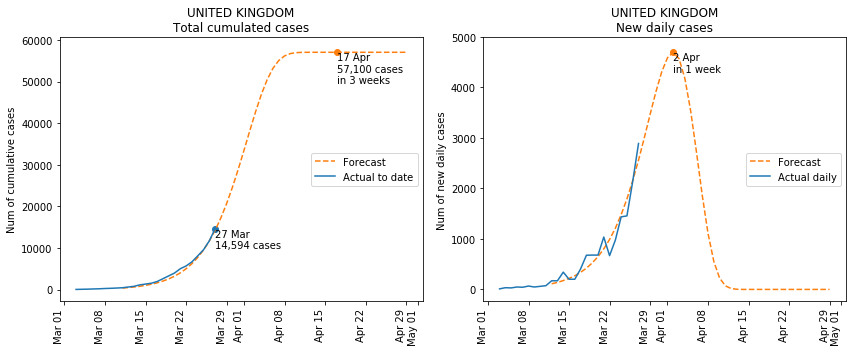

United Kingdom
Auto fit  : A=57057, K=-2099, C=1.0006, Q=0.0001, B=-0.2258, v=0.0173


In [19]:
predict_plot('United Kingdom', days=50, fit_start='20200311', fit_end='20200321')

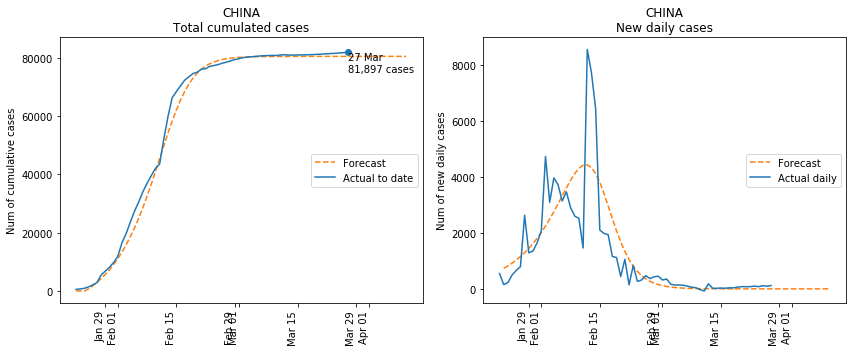

China
Auto fit  : A=-7717, K=6648, C=0.0096, Q=9.3326, B=0.2951, v=2.5621


In [20]:
predict_plot('China', days=80, showzero=False, fit_end='20200323')

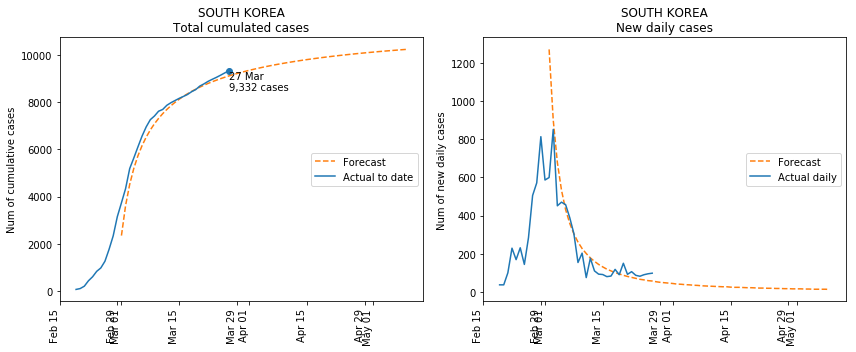

South Korea
Auto fit  : A=11136, K=8959, C=-2.0483, Q=2.1657, B=-0.0146, v=1.5349


In [41]:
#predict_plot('South Korea', rolling=0, days=50, showzero=False, fit_end='20200323')
predict_plot('South Korea', days=70, showzero=False, fit_start='20200301', fit_end='20200326')

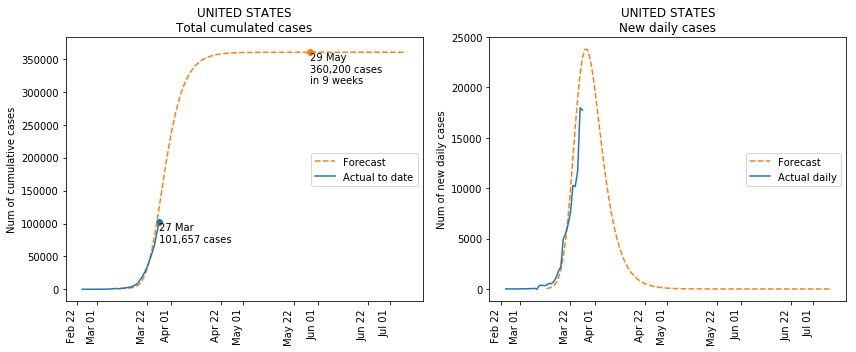

United States
Auto fit  : A=1422, K=2316, C=0.3143, Q=1.3323, B=0.1816, v=0.2133
Manual fit: A=1422, K=3000, C=0.3143, Q=2, B=0.2, v=0.2133


In [22]:
#predict_plot('United States', days=100, fit_start='20200316', fit_end='20200321', showpeak=False, B=-1.5)
#predict_plot('United States', fit_start='20200311', fit_end='20200325', days=100, B=0.3, Q=4)
#predict_plot('United States', days=200, fit_start='20200311', fit_end='20200325', B=0.15, K=4000)
predict_plot('United States', fit_start='20200311', fit_end='20200325', days=120, B=0.2, K=3000, Q=2)

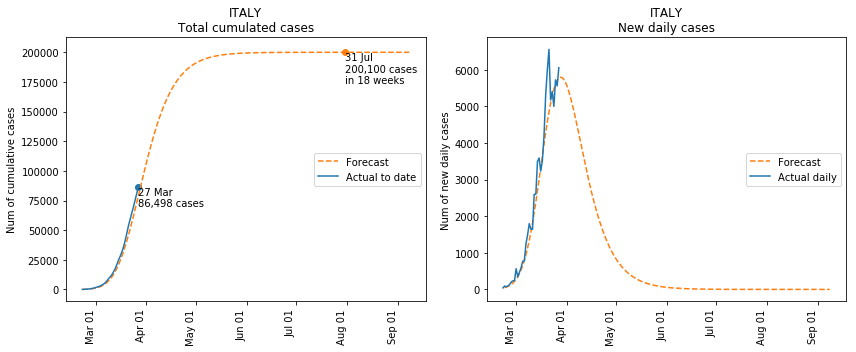

Italy
Auto fit  : A=-94, K=2952, C=0.3288, Q=1.9149, B=0.0891, v=0.2658


In [23]:
predict_plot('Italy', days=200, showpeak=False, fit_end='20200319')

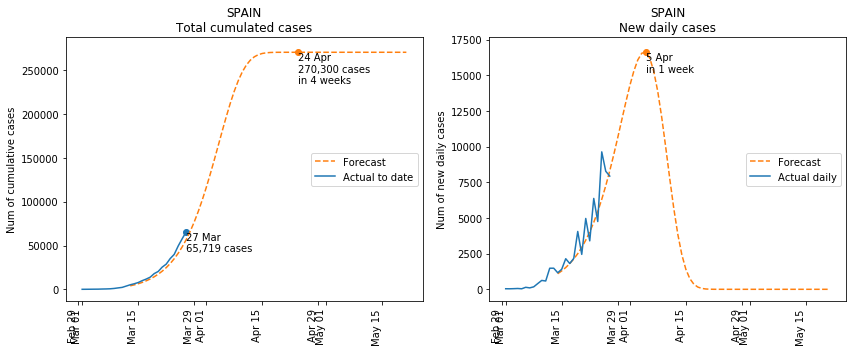

Spain
Auto fit  : A=270280, K=-12797, C=1.003, Q=0.0016, B=-0.1726, v=0.0746


In [24]:
predict_plot('Spain', days=70, fit_start='20200313', fit_end='20200323')

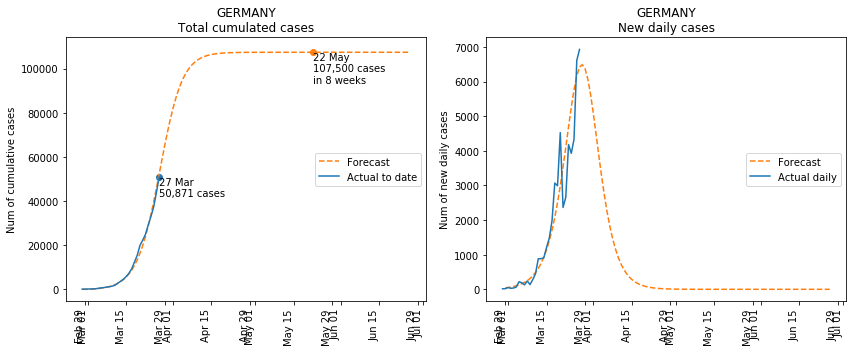

Germany
Auto fit  : A=-8, K=167, C=0.0023, Q=3.1241, B=0.3035, v=1.1152
Manual fit: A=-300, K=167, C=0.0023, Q=3.1241, B=0.25, v=1.1152


In [25]:
predict_plot('Germany', rolling=1, days=120, fit_end='20200317', showpeak=False, A=-300, B=0.25)

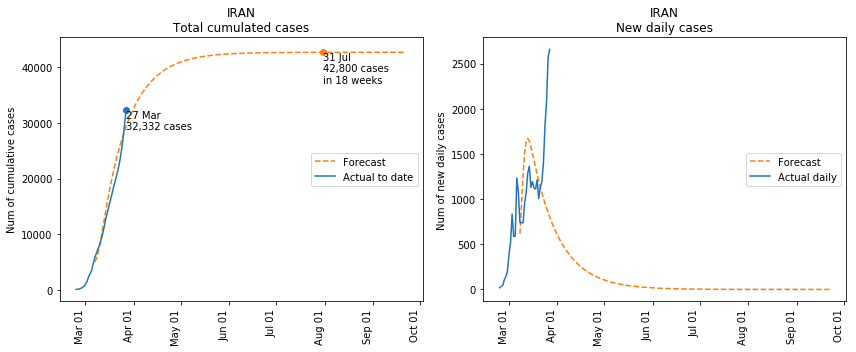

Iran
Auto fit  : A=42715, K=3417, C=1.2854, Q=0.3518, B=-0.4193, v=9.1439
Manual fit: A=42715, K=3417, C=1.2854, Q=0.3518, B=-0.7, v=12


In [26]:
predict_plot('Iran', days=200, fit_start='20200307', fit_end='20200321', B=-0.7, v=12)
#predict_plot('Iran', days=200, fit_start='20200309', fit_end='20200321')

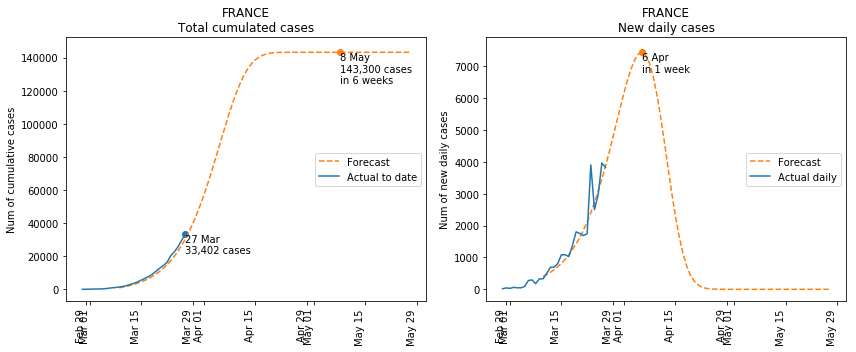

France
Auto fit  : A=143208, K=-20663, C=1.013, Q=0.0019, B=-0.1472, v=0.1046


In [27]:
predict_plot('France', days=80, fit_start='20200309', fit_end='20200320')

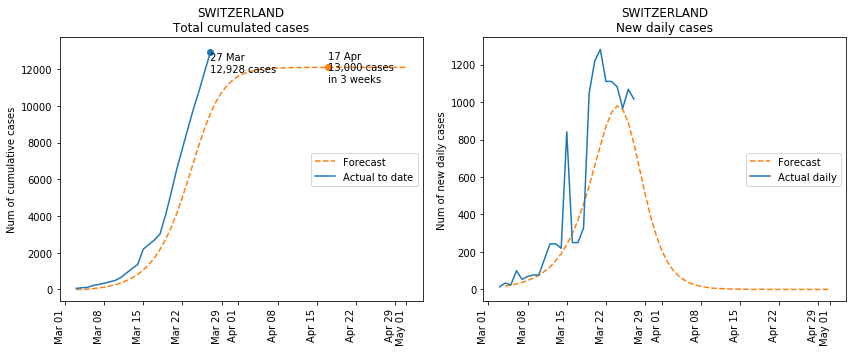

Switzerland
Auto fit  : A=-26, K=395, C=0.003, Q=13.1054, B=0.3825, v=1.6262
Manual fit: A=-100, K=240, C=0.003, Q=13.1054, B=0.3825, v=1.6262


In [28]:
predict_plot('Switzerland', days=60, K=240, A=-100)

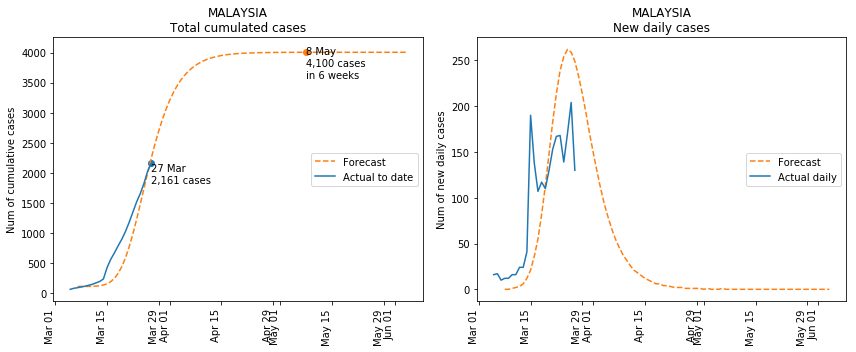

Malaysia
Auto fit  : A=113, K=199, C=0.6101, Q=4.4736, B=0.3538, v=0.1894
Manual fit: A=113, K=400, C=0.6101, Q=4, B=0.2, v=0.1894


In [29]:
#predict_plot('Malaysia', days=60, fit_start='20200311', fit_end='20200320', K=300, B=0.3, Q=5)
#predict_plot('Malaysia', days=60, fit_start='20200307', fit_end='20200320', K=300, B=0.3, Q=5)
predict_plot('Malaysia', days=90, fit_start='20200307', fit_end='20200320', K=400, B=0.2, Q=4)
#predict_plot('Malaysia', days=100, fit_start='20200313', fit_end='20200325')

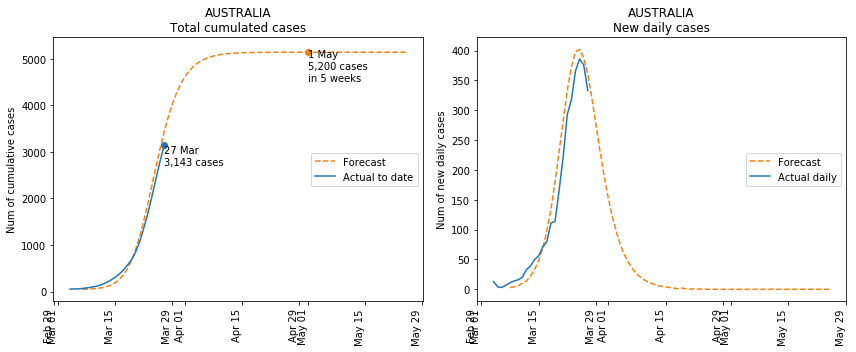

Australia
Auto fit  : A=45, K=119, C=0.1527, Q=2.4371, B=0.2325, v=0.6275
Manual fit: A=45, K=300, C=0.1527, Q=12, B=0.28, v=0.6275


In [30]:
#predict_plot('Australia', days=60, fit_end='20200317', B=0.25, showpeak=False)
predict_plot('Australia', days=80, fit_start='20200307', fit_end='20200317', showpeak=False, B=0.28, K=300, Q=12)

In [31]:
# predict_plot('Indonesia', days=100, fit_start='20200316', showpeak=False, Q=0.5)

In [32]:
# # Generalised logistic function (Richard's curve)
# def richards(x, A, K, C, Q, B, v):
#     y = A + (K-A) / ((C + (Q * np.exp(-1 * B * x))) ** (1/v))
#     return y

# # Fit to Richard's curve model
# def predict_plot(country, rolling=1, fit_start=None, fit_end=None, days=110,
#                  showzero=True, showpeak=True, A=None, K=None, C=None, Q=None, B=None, v=None, df2=df2):

#     # All dates in raw Actuals
#     dates = df2.loc[df2.country==country].reset_index(drop=True).date
#     # All raw Actuals
#     actual0    = df2.loc[df2.country==country, 'confirmed'].reset_index(drop=True)
#     actual0new = df2.loc[df2.country==country, 'new_confirmed'].reset_index(drop=True)

#     # Limit Actual data period for model fit
#     oneday = pd.Timedelta(1, unit='days')
#     fit_start   = pd.to_datetime(fit_start, format='%Y%m%d')
#     fit_end     = pd.to_datetime(fit_end, format='%Y%m%d')
#     index_start = list(dates[dates==fit_start].index)[0] if fit_start != None else None
#     index_end   = list(dates[dates==fit_end+oneday].index)[0] if fit_end != None else None
#     actual1 = actual0.iloc[index_start:index_end]

#     # Data for model fit input after rolling average
#     dropna = range(actual1.index.min(),actual1.index.min()+(rolling-1))
#     actual2 = actual1.rolling(window=rolling).mean().drop(dropna) if rolling > 1 else actual1
#     xdata = np.array(range(rolling,len(actual2)+rolling)) # TO BE CHECKED
#     ydata = np.array(actual2.values)

#     # Auto fit model
#     popt, pcov = curve_fit(richards, xdata, ydata, maxfev=3000)
#     # Hyperparams of auto fit
#     A0, K0, C0, Q0, B0, v0 = popt
    
#     # Overwrite auto fit hyperparams if manual value exists
#     A = A0 if A==None else A
#     K = K0 if K==None else K
#     C = C0 if C==None else C
#     Q = Q0 if Q==None else Q
#     B = B0 if B==None else B
#     v = v0 if v==None else v
    
#     # Calculate prediction over required num of days
#     xdata2 = np.array(range(days))
#     predcalc = richards(xdata2, A, K, C, Q, B, v)
    
#     # Assign prediction into df and shift index to match the correct nth day
#     index = range(actual2.index.min(), days+actual2.index.min()) # TO BE FIXED !!!
#     predict = pd.DataFrame(predcalc, columns=['predict'], index=index)
#     predict = predict.iloc[:,0]
        
#     # Find dates for plot labels
#     # Latest available date in raw Actual
#     latestdate = dates.iloc[-1]
#     # Calculate difference between predicted days to find plateau
#     predict = predict if predict.isna().sum() > 0 else predict.astype('int')
#     newcase0 = predict.diff().drop(predict.index.min())
#     newcase1 = newcase0.iloc[actual2.index.max():] # exclude if zero happens during Actual period
#     # If prediction doesn't coverge to plateau, don't show
#     if np.isnan(newcase1[newcase1==0].index.min()):
#         showzero = False
#     # If prediction converges to plateau:
#     else:
#         # Day when difference between days equal to zero
#         zerocase = newcase1[newcase1==0].index.min()
#         to_go_weeks = math.ceil((zerocase - actual2.index.max())/7)
#         oneday = pd.Timedelta(1, unit='days')
#         zerodate = latestdate + oneday * to_go_weeks * 7
#         # Day when daily peak is reached
#     # If turning point has happened during actuals, don't show
#     if newcase0.max() > newcase1.max():
#         showpeak = False
#     else:
#         turning_point = newcase0[newcase0==newcase0.max()].index[0]
#         to_peak_weeks = math.ceil((turning_point - actual2.index.max())/7)
                
#     fig, ax = plt.subplots(figsize=(12,5), ncols=2, nrows=1)
#     mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    
#     # Plot prediction
#     ax[0].plot(predict.clip(0),  ls='dashed', c='#ff7f0e', label='Forecast')
#     ax[1].plot(newcase0.clip(0), ls='dashed', c='#ff7f0e', label='Forecast')
    
#     # Plot actual
#     ax[0].plot(actual0, c='C0', label='Actual to date')
#     ax[0].scatter(actual0.index[-1], int(actual0.iloc[-1]), c='C0')
#     ax[0].text(actual0.index[-1], actual0.iloc[-1], f'{latestdate.day} {mdict[latestdate.month]}\n{format(int(actual0.iloc[-1]), ",")} cases', va='top')
#     ax[1].plot(actual0new, c='C0', label='Actual daily')
    
#     # Plot actual moving average
#     if rolling > 1:
#         ax[0].plot(actual2, ls=':', label=f'Act {rolling}-day moving avg')

#     # Plot prediction end points
#     if showzero==True:
#         ax[0].scatter(zerocase, predict.max(), c='C1')      
#         predictmax = int(math.ceil(predict.max()/100.0))*100 if predict.max() > actual2.iloc[-1] else int(math.ceil(actual0.iloc[-1]/100.0))*100
#         ax[0].text(zerocase, predictmax, f"{zerodate.day} {mdict[zerodate.month]}\n{format(predictmax, ',')} cases\nin {to_go_weeks} week{'s' if to_go_weeks>1 else ''}", va='top')
#     if showpeak==True:
#         ax[1].scatter(turning_point, newcase0.max(), c='C1')
#         ax[1].text(turning_point, newcase0.max(), f"In {to_peak_weeks} week{'s' if to_peak_weeks>1 else ''}", va='bottom')
    
#     # Plot titles and axis
#     ax[0].set_title(f'{country.upper()}\nTotal cumulated cases')
#     ax[0].set_ylabel('Num of cumulative cases')
#     ax[0].set_xlabel('Days since 50th case')
#     ax[1].set_title(f'{country.upper()}\nNew daily cases')
#     ax[1].set_ylabel('Num of new daily cases')
#     ax[1].set_xlabel('Days since 50th case')
    
#     ax[0].legend(loc='center right')
#     ax[1].legend(loc='center right')
    
#     plt.tight_layout()
#     plt.savefig(f"img/forecast_{country.replace(' ','_')}", pad_inches=0)
#     plt.savefig(f"img_archive/forecast_{country.replace(' ','_')}_{str(latestdate)[:10]}", pad_inches=0)
#     plt.show()
    
#     print(len(dates), len(predict), len(actual0))
#     print(country)
#     print(f'Auto fit  : A={int(A0)}, K={int(K0)}, C={round(C0,4)}, Q={round(Q0,4)}, B={round(B0,4)}, v={round(v0,4)}')
#     if (A!=A0) | (K!=K0) | (C!=C0) | (Q!=Q0) | (B!=B0) | (v!=v0):
#         print(f'Manual fit: A={int(A)}, K={int(K)}, C={round(C,4)}, Q={round(Q,4)}, B={round(B,4)}, v={round(v,4)}')